In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import random
import functions
import hybrid_ann
import matplotlib.pyplot as plt
from RBF import RBF
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
import seaborn as sns
sns.set()
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 16, 8

In [2]:
df = pd.read_csv('beer.csv')
data = df.iloc[:, -1].values

ent = 8

serie_normal = functions.normalizar_serie(data)
serie_lags = functions.gerar_janelas(tam_janela = ent, serie = serie_normal)
X_train, y_train, X_test, y_test = functions.split_serie_with_lags(serie = serie_lags, perc_train = 0.86, perc_val = 0)

In [3]:
mse = np.Inf
for i in range(5):
    model = hybrid_ann.LNL_ANN(m = ent)
    model.fit_MPSO(X = X_train, y = y_train, d= 40, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.5, w2 = 1.0, maxt = 2000)
    if mean_squared_error(y_test, model.predict(X_test)) < mse:
        mse = mean_squared_error(y_test, model.predict(X_test))
        best_model = model
        print('MSE:',mean_squared_error(y_test, best_model.predict(X_test)))

MSE: 0.01073028181128571
MSE: 0.009704756880508024
MSE: 0.009648551333430663
MSE: 0.004435322184583549


In [4]:
model = best_model

# Análise de Dados

## Conjunto de treinamento

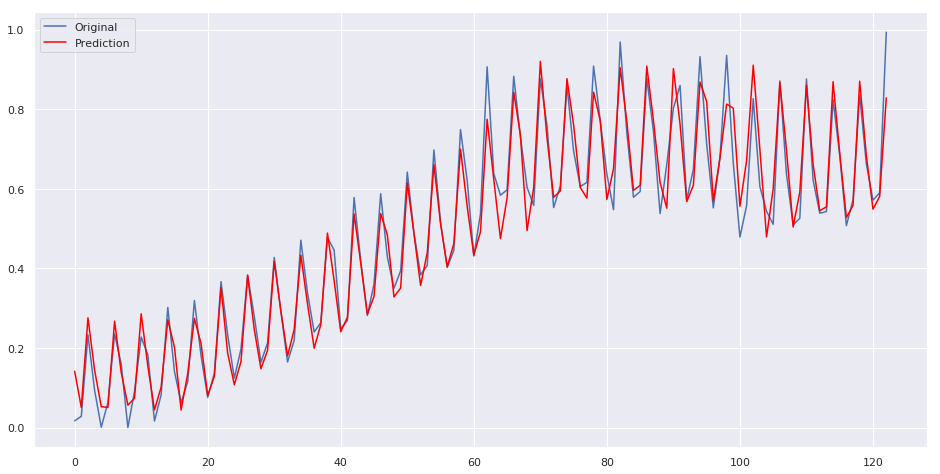

In [45]:
y_train_pred = model.predict(X_train)
plt.plot(y_train, label = 'Original')
plt.plot(y_train_pred, label = 'Prediction', color = 'red')
plt.legend()

## Test Data

In [6]:
y_test_ = functions.desnormalizar(y_test, data).iloc[:,0].values
y_pred = model.predict(X_test)
y_pred_ = functions.desnormalizar(y_pred, data).iloc[:,0].values

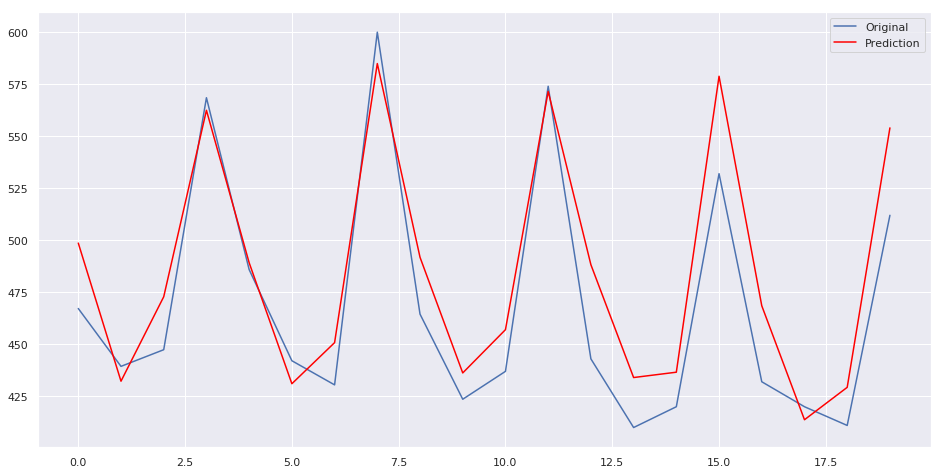

In [46]:
plt.plot(y_test_, label = 'Original')
plt.plot(y_pred_, label = 'Prediction', color = 'red')
plt.legend()

# Erro da série

In [8]:
resid_train = functions._error(y_train, y_train_pred)
resid_test = functions._error(y_test, y_pred)

In [9]:
tam_jan = 2
resid_train_lags = functions.gerar_janelas(tam_janela = tam_jan, serie = resid_train)
resid_test_lags = functions.gerar_janelas(tam_janela = tam_jan, serie = resid_test)

In [10]:
#Treinamento
X_error_train = resid_train_lags[:, :-1]
y_error_train = resid_train_lags[:, -1]

#Teste
X_error_test = resid_test_lags[:, :-1]
y_error_test = resid_test_lags[:, -1]

# Modelo Proposto 1:

<img src="model1.png">

In [11]:
mse = np.Inf
for i in range(5):
    model_resid = hybrid_ann.LNL_ANN(m = tam_jan)
    model_resid.fit_MPSO(X = X_error_train, y = y_error_train, d= 40, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.2, w2 = 0.8, maxt = 2000)
    if mean_squared_error(y_error_test, model_resid.predict(X_error_test)) < mse:
        mse = mean_squared_error(y_error_test, model_resid.predict(X_error_test))
        best_model = model_resid
        print('MSE:', mse)

MSE: 0.003663952605420504
MSE: 0.0030465808698113455


In [12]:
model_resid = best_model

In [13]:
resid_pred = model_resid.predict(X_error_test)
resid_pred_ = functions.desnormalizar(y_pred[tam_jan+1:] + resid_pred,data).iloc[:,0].values

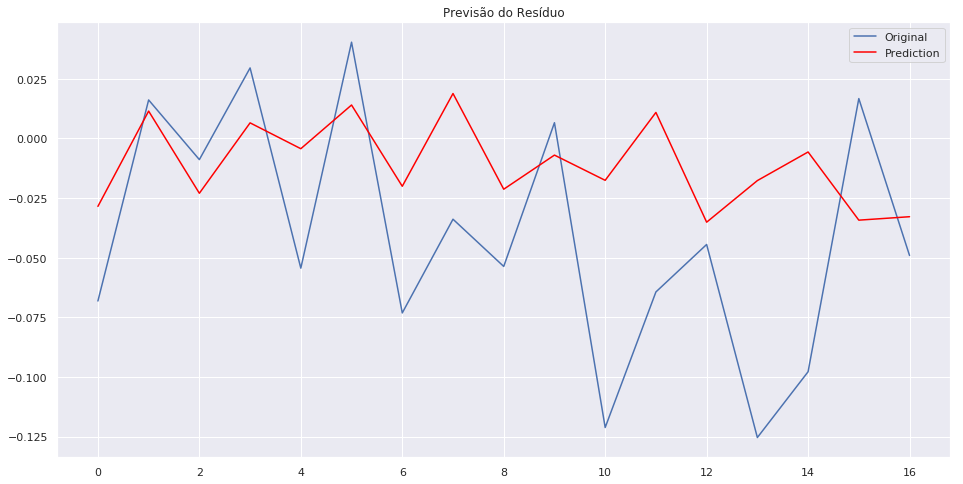

In [47]:
plt.plot(y_error_test, label = 'Original')
plt.plot(resid_pred, label = 'Prediction', color = 'red')
plt.title('Previsão do Resíduo')
plt.legend()

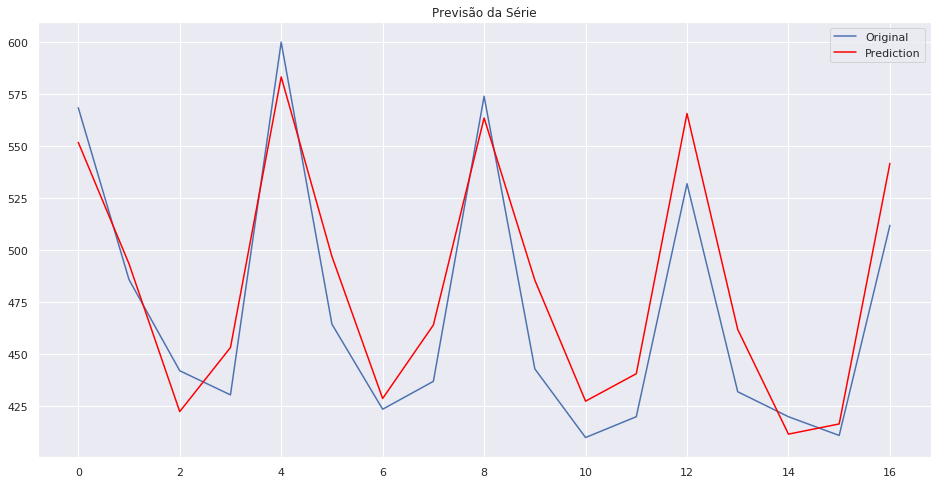

In [48]:
plt.plot(y_test_[tam_jan+1:], label = 'Original')
plt.plot(resid_pred_, label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

# Modelo Proposto 2:

<img src="model2.png">

In [16]:
X_train_e = np.hstack((X_train[1:, :], resid_train[:-1].reshape(-1, 1)))
X_test_e = np.hstack((X_test[1:, :], resid_test[:-1].reshape(-1,1)))

In [17]:
mse = np.Inf
for i in range(5):
    model2 = hybrid_ann.Hybrid_ANN(model.weight)
    model2.fit_MPSO(X = X_train_e, y = y_train[1:], d= 40, c1i = 0.5, c1f = 1.5, c2i = 0.5, c2f = 1.5, w1 = 0.2, w2 = 0.8, maxt = 2000)
    if mean_squared_error(y_test[1:], model2.predict(X_test_e)) < mse:
        mse = mean_squared_error(y_test[1:], model2.predict(X_test_e))
        best_model = model2
        print('MSE:', mse)

MSE: 0.004234869335849022
MSE: 0.004185255764539334
MSE: 0.004134512055198129


In [18]:
model2 = best_model

In [19]:
y_pred2 = model2.predict(X_test_e)
y_pred2_ = functions.desnormalizar(y_pred2, data).iloc[:,0].values

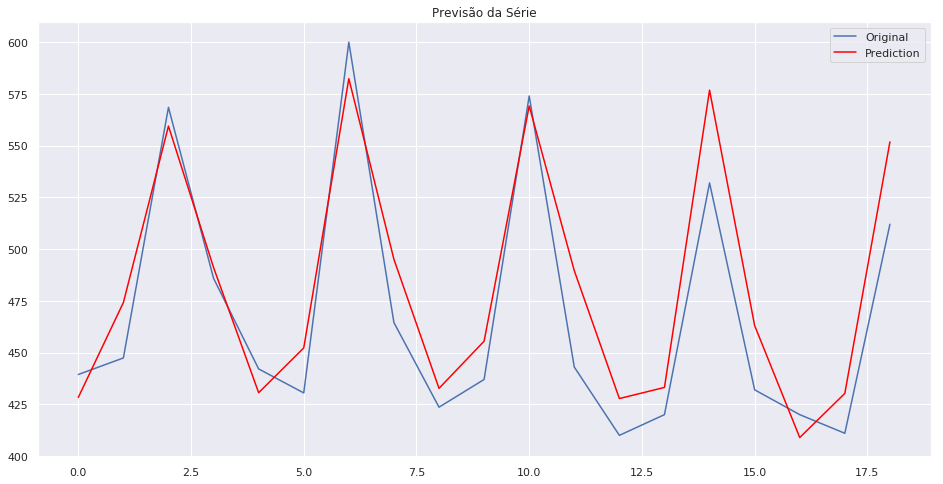

In [49]:
plt.plot(functions.desnormalizar(y_test[1:],data), label = 'Original')
plt.plot(y_pred2_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

## Comparação entre os modelos

### RBF

In [21]:
rbf = RBF(8, 32, 1)
rbf.train(X_train, y_train)
z = rbf.test(X_test)
z_ = functions.desnormalizar(z, data).iloc[:,0].values

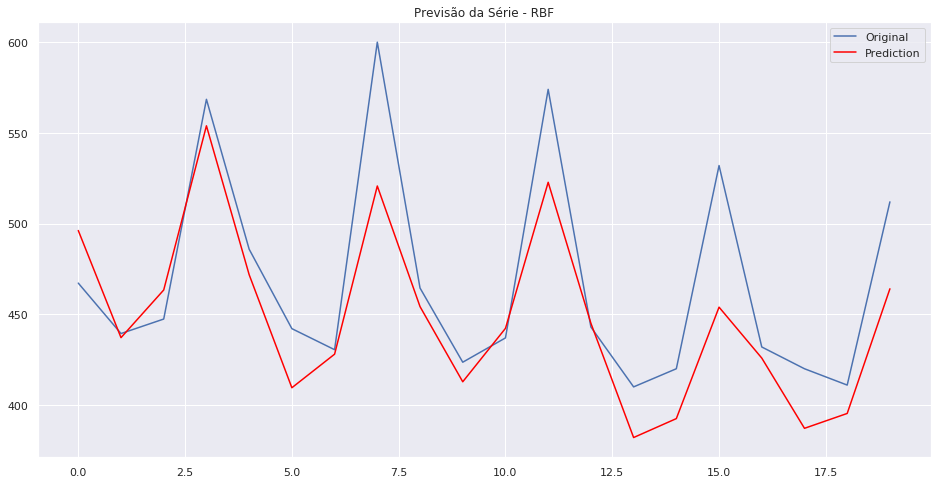

In [50]:
plt.plot(y_test_, label = 'Original')
plt.plot(z_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - RBF')
plt.legend()

### FFANN

In [23]:
ffann = MLPRegressor(hidden_layer_sizes=(20,),activation= 'tanh',solver='adam', max_iter=1000)
ffann.fit(X_train, y_train)
ffann_pred = ffann.predict(X_test)
ffann_ = functions.desnormalizar(ffann_pred, data).iloc[:,0].values

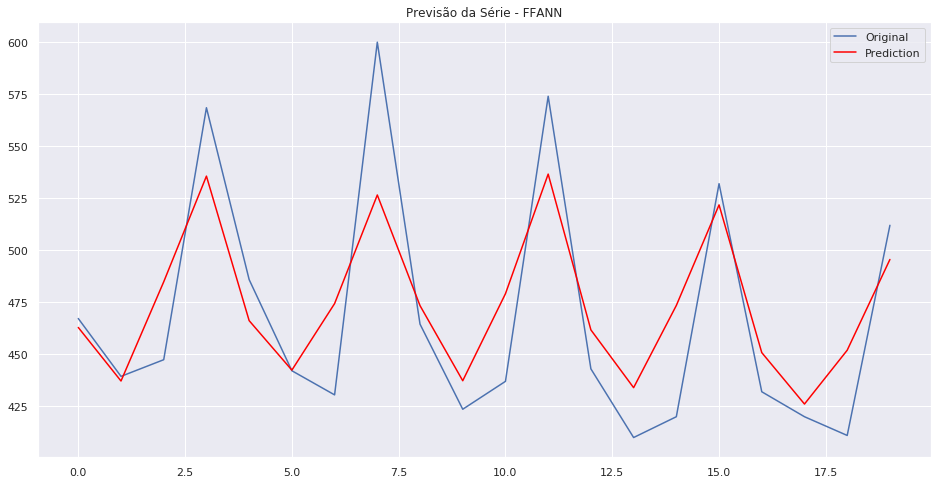

In [51]:
plt.plot(y_test_, label = 'Original')
plt.plot(ffann_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - FFANN')
plt.legend()

### WMES

In [79]:
ref = len(data) - len(y_test_)
fit2 = ExponentialSmoothing(data[:ref-2], seasonal_periods = 4, trend='add', seasonal='mul').fit(use_boxcox=True)
wmes = fit2.forecast(len(y_test_))

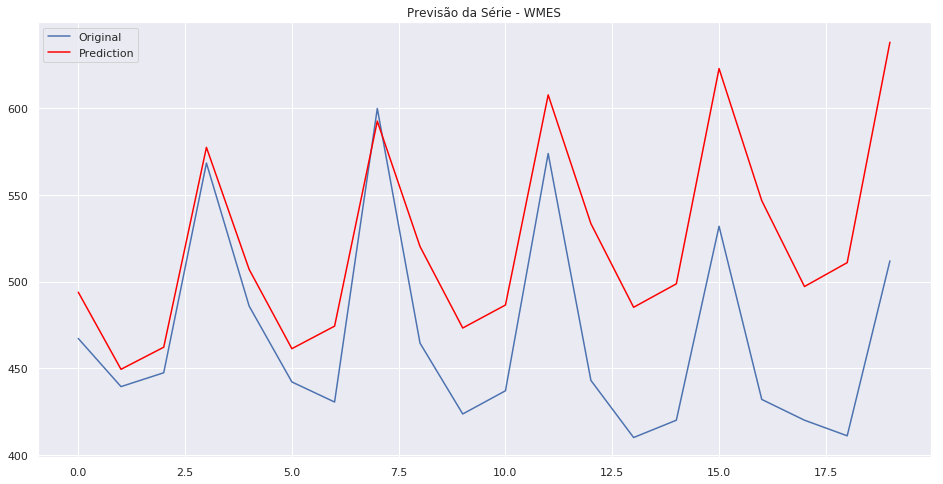

In [80]:
plt.plot(y_test_, label = 'Original')
plt.plot(wmes , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - WMES')
plt.legend()

### SARIMA

In [91]:
historico = [x for x in data[:ref]]
previsoes = []
for i in range(len(y_test_)):
    modelo = sm.tsa.statespace.SARIMAX(historico, order=(0,1,1),seasonal_order=(0,1,1,4)).fit()
    prev = modelo.forecast()[0]
    previsoes.append(prev)
    obs = y_test_[i]
    historico.append(obs)

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


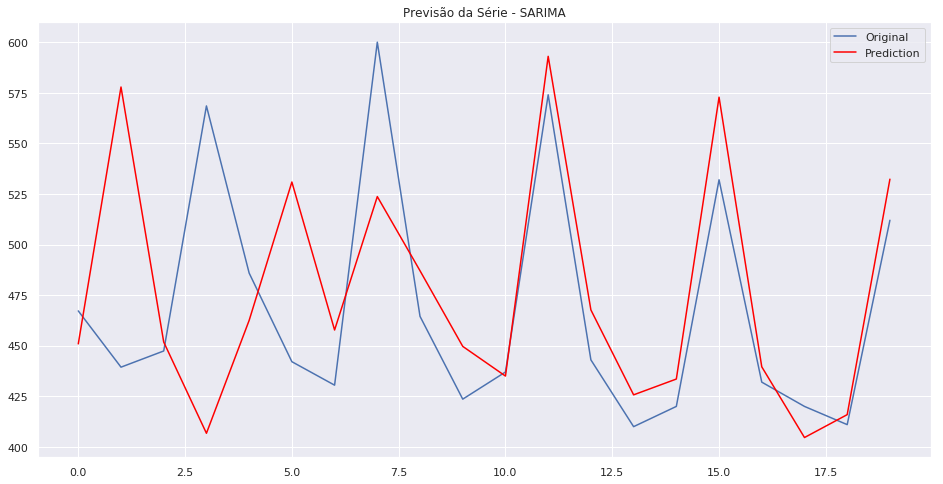

In [92]:
sarima = previsoes[:]
plt.plot(y_test_, label = 'Original')
plt.plot(sarima , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - SARIMA')
plt.legend()

# Resultados

In [81]:
Forecasts = pd.DataFrame(
{
'Test data': y_test_,
'SARIMA': sarima,
'WMES': wmes,
'FFANN': ffann_,
'RBF': z_,
'L&NL-ANN': y_pred_
}
)

Metrics = pd.DataFrame(
{
'SARIMA': [functions.RMSE(y_test_, sarima), functions.MAPE(y_test_, sarima), functions.MdAPE(y_test_, sarima), functions.DA(y_test_, sarima)],
'WMES': [functions.RMSE(y_test_, wmes), functions.MAPE(y_test_, wmes), functions.MdAPE(y_test_, wmes), functions.DA(y_test_, wmes)],
'FFANN': [functions.RMSE(y_test_, ffann_), functions.MAPE(y_test_, ffann_), functions.MdAPE(y_test_, ffann_), functions.DA(y_test_, ffann_)],
'RBF': [functions.RMSE(y_test_, z_), functions.MAPE(y_test_, z_), functions.MdAPE(y_test_, z_), functions.DA(y_test_, z_)],
'L&NL-ANN': [functions.RMSE(y_test_, y_pred_), functions.MAPE(y_test_, y_pred_), functions.MdAPE(y_test_, y_pred_), functions.DA(y_test_, y_pred_)],
}, index = ['RMSE', 'MAPE', 'MdAPE', 'DA']
)

#Falta criar os outros modelos e inserir os respectivos conjuntos de previsão em cada função de erro.

In [82]:
Forecasts

,Test data,SARIMA,WMES,FFANN,RBF,L&NL-ANN
0,467.2,450.898615,493.917097,462.903027,496.193193,498.643980
1,439.4,577.842650,449.400362,437.165991,437.142361,432.272214
2,447.4,451.811600,462.148132,484.836167,463.415101,472.844783
3,568.5,406.729109,577.563569,535.632879,553.906978,562.466310
4,485.9,462.525942,507.090003,466.177151,471.854965,489.205728
5,442.1,530.900689,461.309375,442.394779,409.527884,431.049943
6,430.5,457.765192,474.322068,474.374246,428.034230,450.802299
7,600.0,523.700651,592.696581,526.567590,520.734102,584.920905
8,464.5,487.038247,520.292140,473.379858,454.257428,491.813715
9,423.6,449.670910,473.244649,437.299970,412.823996,436.238178


In [83]:
Metrics

,SARIMA,WMES,FFANN,RBF,L&NL-ANN
RMSE,57.274903,65.768051,31.526378,33.927877,24.874433
MAPE,0.077022,0.121270,0.053568,0.051336,0.045409
MdAPE,0.043881,0.115261,0.042916,0.036922,0.045204
DA,0.789474,0.684211,0.894737,0.947368,0.894737


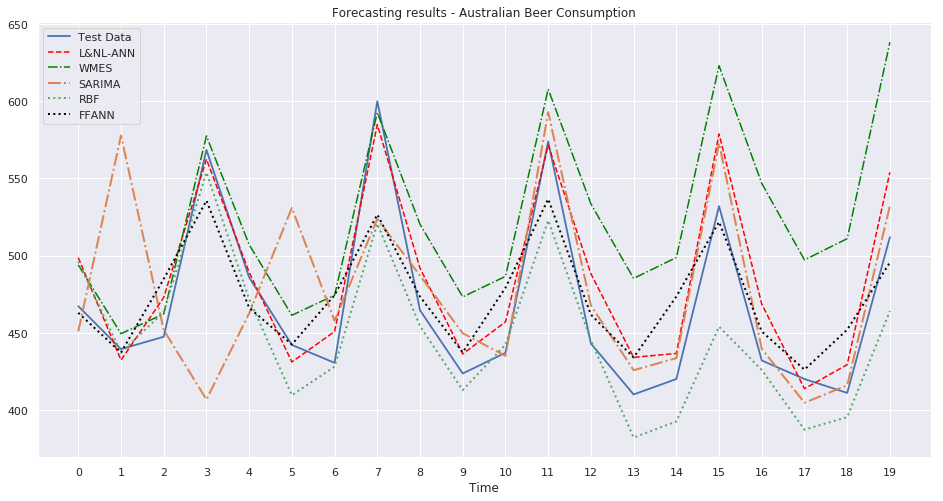

In [106]:
plt.plot(y_test_, label = 'Test Data', linewidth=1.8)
plt.plot(y_pred_, label = 'L&NL-ANN', color = 'red', linestyle='--')
plt.plot(wmes, label = 'WMES', linestyle='-.', color = 'green')
plt.plot(sarima , label = 'SARIMA', linestyle='-.', linewidth=2)
plt.plot(z_ , label = 'RBF', linestyle=':', linewidth=2)
plt.plot(ffann_ , label = 'FFANN', linestyle=':', color = 'black', linewidth=2)
plt.xticks(np.arange(len(y_test_)))
plt.xlabel('Time')
plt.legend()
plt.title('Forecasting results - Australian Beer Consumption')
plt.show()

# Comparação entre Modelos L&NL

In [88]:
Metrics2 = pd.DataFrame(
{
'RMSE': [functions.RMSE(y_test_, y_pred_), functions.RMSE(y_test_[3:], resid_pred_), functions.RMSE(y_test_[1:], y_pred2_)],
'MAPE': [functions.MAPE(y_test_, y_pred_), functions.MAPE(y_test_[3:], resid_pred_),functions.MAPE(y_test_[1:], y_pred2_)],
'MdAPE': [functions.MdAPE(y_test_, y_pred_), functions.MdAPE(y_test_[3:], resid_pred_),functions.MdAPE(y_test_[1:], y_pred2_)],
'DA': [functions.DA(y_test_, y_pred_), functions.DA(y_test_[3:], resid_pred_),functions.DA(y_test_[1:], y_pred2_)]
}, index = ['L&NL-ANN', 'Model 1', 'Model 2']
)

Metrics2.T

,L&NL-ANN,Model 1,Model 2
RMSE,24.874433,23.028453,24.016114
MAPE,0.045409,0.043801,0.044346
MdAPE,0.045204,0.044390,0.042344
DA,0.894737,0.937500,0.888889


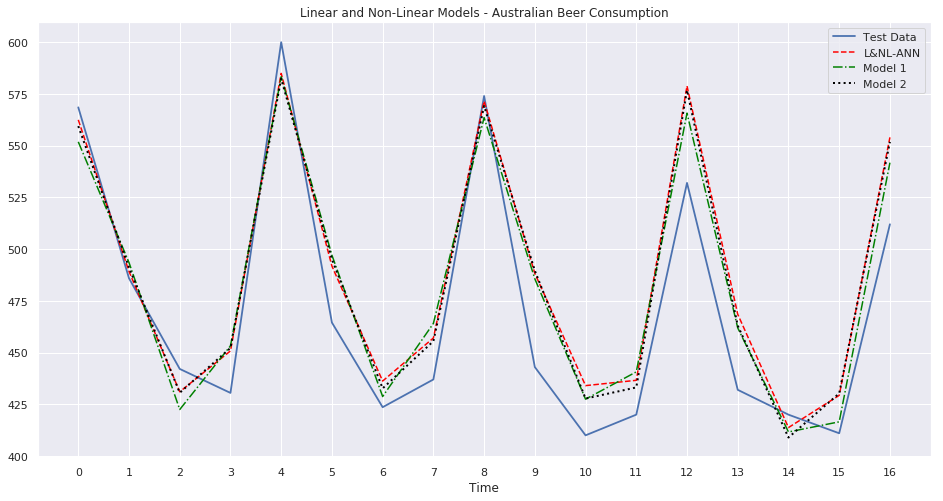

In [104]:
plt.plot(y_test_[tam_jan+1:], label = 'Test Data', linewidth=1.8)
plt.plot(y_pred_[tam_jan+1:], label = 'L&NL-ANN', color = 'red', linestyle='--')
plt.plot(resid_pred_, label = 'Model 1', linestyle='-.', color = 'green')
plt.plot(y_pred2_[tam_jan:] , label = 'Model 2', linestyle=':', color = 'black', linewidth=2)
plt.legend()
plt.title('Linear and Non-Linear Models - Australian Beer Consumption')
plt.xticks(np.arange(len(resid_pred_)))
plt.xlabel('Time')
plt.show()